In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['KERAS_BACKEND'] = "tensorflow"
import keras
import keras.backend as K
from keras import layers, Model
from keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# import tensorflow as tf

from modules.dataset import EquilibratedDataset
from modules.encoding import ProteinOneHotEncoder

# from modules.data.loader import SequenceEncodingDataGenerator

2025-09-03 16:48:57.467338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
plt.style.use('seaborn-v0_8')

## Encoding

### NLF

We want to encode the sequence first, and retrieve the encoded for each sequence in the join later.

In [3]:
encoder = ProteinOneHotEncoder()

In [4]:
vector_size = 200
X, y, vector_size, alphabet_size = EquilibratedDataset(encoder).getdata(vector_size)

x_ab, x_ag = X


In [5]:
x_train_ab, x_test_ab, x_train_ag, x_test_ag, y_train, y_test = train_test_split(x_ab, x_ag, y, test_size=0.2, random_state=42, stratify=y)


In [6]:
input_dimensions = (vector_size, alphabet_size)
input_dimensions

(200, 22)

## Siamese network

In [7]:
seq_input1 = layers.Input(shape=input_dimensions, name='seq_ag')
seq_input2 = layers.Input(shape=input_dimensions, name='seq_ab')

In [8]:
# Convolutional modules
filters = 96


conv01 = layers.Conv1D(filters, 11, padding='same', activation="relu")
mp1 = layers.MaxPooling1D(3)
conv02 = layers.Conv1D(filters*2, 7, padding='same', activation="relu")
mp2 = layers.MaxPooling1D(3)
conv03 = layers.Conv1D(filters*4, 3, padding='same', activation="relu")
mp3 = layers.MaxPooling1D(3)
conv04 = layers.Conv1D(filters*2, 3, padding='same', activation="relu")
mp4 = layers.MaxPooling1D(3)

gru = layers.Bidirectional(layers.GRU(filters, return_sequences=False))

def siamese_propagation(x):
    x = conv01(x)
    x = mp1(x)

    x = conv02(x)
    x = mp2(x)

    x = conv03(x)
    x = mp3(x)

    x = conv04(x)
    x = mp4(x)

    x_gru = gru(x)
    return x_gru



2025-09-03 16:49:12.571858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
def forward(left, right):
    left = siamese_propagation(left)
    right = siamese_propagation(right)

    merge = layers.multiply([left, right])

    # merge = layers.Dense(filters*2, activation='relu')(merge)
    merge = layers.Dropout(0.2)(merge)
    return layers.Dense(1, activation='sigmoid')(merge)

In [10]:
def f1(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    pred_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (pred_pos + K.epsilon())
    recall = tp / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def mcc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

def accuracy(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    return (tp + tn) / (tp + tn + fp + fn)

In [11]:
def binary_crossentropy(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = - K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
    return loss

In [12]:
model = Model(inputs=[seq_input1, seq_input2],
            outputs=[forward(seq_input1, seq_input2)])

adam = Adam(learning_rate=1e-4, amsgrad=True, epsilon=1e-6)

checkpoint_callback = keras.callbacks.ModelCheckpoint(f'run/models/siamese/one-hot-{vector_size}-model.h5', monitor='val_mcc', mode='max')
earlystop_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

model.compile(optimizer=adam, loss=binary_crossentropy, metrics=[accuracy, f1, mcc])


history = model.fit([x_train_ab, x_train_ag], y_train, epochs=50, callbacks=[checkpoint_callback, earlystop_callback],
          batch_size=64, verbose=1, validation_split=0.15)


Epoch 1/50


2025-09-03 16:49:17.094444: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 270969600 exceeds 10% of free system memory.
2025-09-03 16:49:17.328330: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 270969600 exceeds 10% of free system memory.


241/241 [==============================] - 26s 96ms/step - loss: 0.6744 - accuracy: 0.5671 - f1: 0.4991 - mcc: 0.1738 - val_loss: 0.6296 - val_accuracy: 0.6456 - val_f1: 0.5213 - val_mcc: 0.3689
Epoch 2/50
241/241 [==============================] - 22s 92ms/step - loss: 0.5741 - accuracy: 0.6862 - f1: 0.6450 - mcc: 0.3864 - val_loss: 0.5365 - val_accuracy: 0.7201 - val_f1: 0.6963 - val_mcc: 0.4564
Epoch 3/50
241/241 [==============================] - 22s 91ms/step - loss: 0.5270 - accuracy: 0.7337 - f1: 0.7009 - mcc: 0.4897 - val_loss: 0.5084 - val_accuracy: 0.7511 - val_f1: 0.7154 - val_mcc: 0.5359
Epoch 4/50
241/241 [==============================] - 22s 91ms/step - loss: 0.4741 - accuracy: 0.7769 - f1: 0.7512 - mcc: 0.5660 - val_loss: 0.4708 - val_accuracy: 0.7732 - val_f1: 0.7814 - val_mcc: 0.5486
Epoch 5/50
241/241 [==============================] - 22s 92ms/step - loss: 0.4325 - accuracy: 0.8066 - f1: 0.7876 - mcc: 0.6235 - val_loss: 0.4267 - val_accuracy: 0.8104 - val_f1: 0.8083

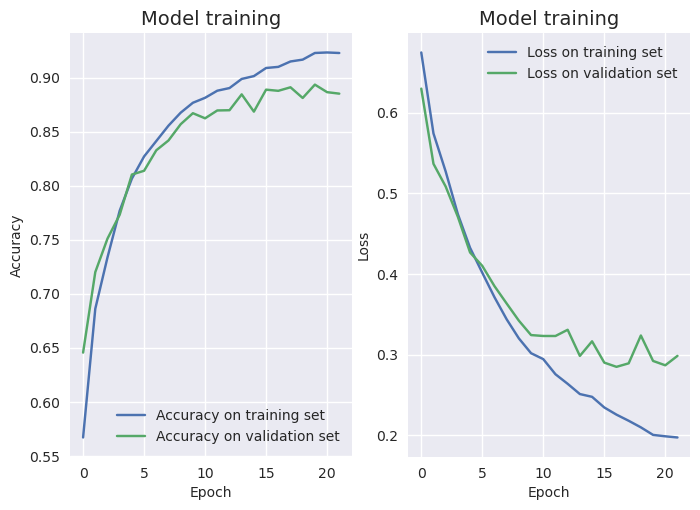

In [20]:
plt.figure()
plt.subplot(121)
plt.plot(history.history['accuracy'], label = "Accuracy on training set")
plt.plot(history.history['val_accuracy'], label = "Accuracy on validation set")
plt.title('Model training', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 10)
plt.xlabel('Epoch', fontsize = 10)
plt.legend(fontsize = 10)

plt.subplot(122)
plt.plot(history.history['loss'], label = "Loss on training set")
plt.plot(history.history['val_loss'], label = "Loss on validation set")
plt.title('Model training', fontsize = 14)
plt.ylabel('Loss', fontsize = 10)
plt.xlabel('Epoch', fontsize = 10)
plt.legend(fontsize = 10)
plt.savefig('../plots/Siamese_training.png')
plt.show()

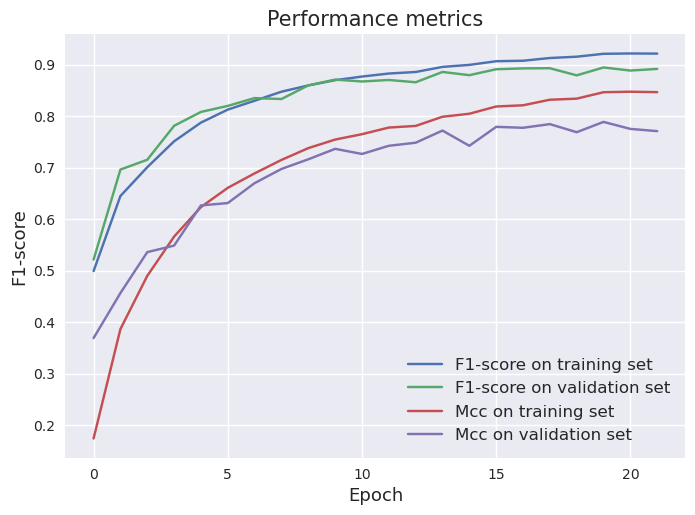

In [27]:
plt.figure()
# plt.subplot(121)
plt.plot(history.history['f1'], label = "F1-score on training set")
plt.plot(history.history['val_f1'], label = "F1-score on validation set")

plt.plot(history.history['mcc'], label = "Mcc on training set")
plt.plot(history.history['val_mcc'], label = "Mcc on validation set")

# plt.title('Model training', fontsize = 14)
plt.ylabel('F1-score', fontsize = 13)
plt.xlabel('Epoch', fontsize = 13)
plt.title('Performance metrics', fontsize = 15)
plt.legend(fontsize = 12)

# plt.subplot(122)
# plt.plot(history.history['loss'], label = "Loss on training set")
# plt.plot(history.history['val_loss'], label = "Loss on validation set")
# # plt.title('Model training', fontsize = 14)
# plt.ylabel('Loss', fontsize = 10)
# plt.xlabel('Epoch', fontsize = 10)
# plt.legend(fontsize = 10)
# plt.suptitle("Model Training", fontsize = 15)
# plt.savefig('../plots/Siamese_training.png')
plt.show()